In [1]:
import torch
import torch.nn as nn
from scratch_model import VisionTransformer

In [2]:
#check if we can run this code with GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [3]:
from train_utils import train, validate, save_model, save_plots, get_n_params
from save_best_model import SaveBestModel
save_best_model = SaveBestModel()

In [4]:
model_config = {
    "img_size": 32,
    "patch_size": 4,
    "in_chans": 3,
    "n_classes": 10,
    "embed_dim": 256,
    "depth": 12,
    "n_heads": 8,
    "mlp_ratio": 4.,
    "qkv_bias": True,}

In [5]:
RA_model = VisionTransformer(**model_config).to(device)
RA_model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=10, bias=True

In [6]:
get_n_params(RA_model)

9509642

In [7]:
import pickle
from torchvision.transforms import transforms
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [8]:
#import train data
with open('imbalanced_data.pkl', 'rb') as f:
    imbalanced_data = pickle.load(f)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
from torchvision.transforms import RandAugment
augmenter = RandAugment()

In [10]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.26733429, 0.25643846, 0.27615047])
                                ])

trainsize = int(len(imbalanced_data)*0.8)
RA_train_data, RA_val_data = torch.utils.data.random_split(imbalanced_data, [trainsize, len(imbalanced_data) - trainsize])

cat_data = [(image,label) for image, label in RA_train_data if label == 3]
other_data = [(image,label) for image, label in RA_train_data if label != 3]

nb = 9

augment_data = []
for image, label in cat_data :
    img = [augmenter(image) for _ in range(nb)]
    img.append(image)
    for i in img :
        augment_data.append((i,label))

RA_data = augment_data + other_data
RA_train_set = [(transform(image), label) for image, label in RA_data]
RA_val_set = [(transform(image), label) for image, label in RA_val_data]

i = 0
j = []
for k in range(10) :
    for image ,label in RA_val_set :
        if label == k :
            i = i + 1
    j.append(i)
    i = 0
print("différents nombres de labels selon chaque classe dans le validation set :", j)

différents nombres de labels selon chaque classe dans le validation set : [974, 1047, 1022, 99, 983, 999, 1053, 972, 980, 971]


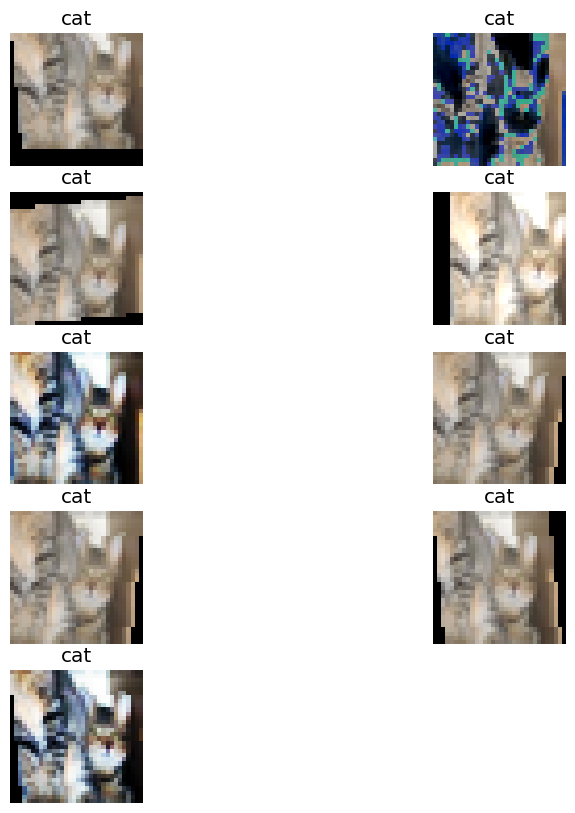

In [11]:
plt.figure(figsize=(10, 10))
for i in range(nb):
    plt.subplot(5, 2, i + 1)
    plt.imshow(augment_data[i][0])
    plt.title(class_names[augment_data[i][1]])
    plt.axis('off')

In [12]:
EPOCHS = 20
BATCH_SIZE = 128
LR = 3e-4

In [13]:
from train_utils import weight_classes, weight_calculation

In [14]:
labels = []
for image, label in RA_train_data :
    labels.append(label)

labels_unique = np.unique(labels)

weight_params = weight_classes(labels_unique, labels)

In [15]:
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight_params).to(device))
optimizer = torch.optim.Adam(RA_model.parameters(), lr = LR)

loader_kwargs = ({'num_workers' : 4, 'pin_memory': True} if torch.cuda.is_available() == True else {})
RA_train_loader = data.DataLoader(RA_train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, **loader_kwargs)
RA_val_loader = data.DataLoader(RA_val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, **loader_kwargs)

[INFO]: Epoch 1 of 20
Training


100%|██████████| 312/312 [00:35<00:00,  8.80it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.90it/s]


Training loss: 1.359, training acc: 24.822
Validation loss: 1.869, validation acc: 28.967

Best validation loss: 1.869239057103793

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


100%|██████████| 312/312 [00:31<00:00,  9.87it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 26.89it/s]


Training loss: 1.093, training acc: 37.157
Validation loss: 1.824, validation acc: 33.516

Best validation loss: 1.8241964942879147

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


100%|██████████| 312/312 [00:31<00:00,  9.82it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 26.82it/s]


Training loss: 0.943, training acc: 45.337
Validation loss: 1.451, validation acc: 47.198

Best validation loss: 1.4514432052771251

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


100%|██████████| 312/312 [00:31<00:00,  9.85it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 26.80it/s]


Training loss: 0.837, training acc: 50.951
Validation loss: 1.389, validation acc: 52.462

Best validation loss: 1.3894518613815308

Saving best model for epoch: 4

--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


100%|██████████| 312/312 [00:31<00:00,  9.85it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 26.75it/s]


Training loss: 0.748, training acc: 55.468
Validation loss: 1.380, validation acc: 54.352

Best validation loss: 1.3799826933277979

Saving best model for epoch: 5

--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


100%|██████████| 312/312 [00:30<00:00, 10.12it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 27.71it/s]


Training loss: 0.697, training acc: 58.304
Validation loss: 1.353, validation acc: 54.187

Best validation loss: 1.3527763858437538

Saving best model for epoch: 6

--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.51it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.94it/s]


Training loss: 0.645, training acc: 60.951
Validation loss: 1.304, validation acc: 57.220

Best validation loss: 1.3044424487484827

Saving best model for epoch: 7

--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.52it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.90it/s]


Training loss: 0.610, training acc: 62.638
Validation loss: 1.356, validation acc: 55.747
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.51it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 26.00it/s]


Training loss: 0.576, training acc: 64.668
Validation loss: 1.309, validation acc: 58.473
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.73it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 28.96it/s]


Training loss: 0.536, training acc: 66.648
Validation loss: 1.331, validation acc: 60.418
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.46it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.72it/s]


Training loss: 0.525, training acc: 67.575
Validation loss: 1.373, validation acc: 60.176
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.47it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.79it/s]


Training loss: 0.496, training acc: 69.267
Validation loss: 1.335, validation acc: 58.527
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.50it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.52it/s]


Training loss: 0.471, training acc: 70.249
Validation loss: 1.297, validation acc: 60.857

Best validation loss: 1.2970970198512077

Saving best model for epoch: 13

--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.54it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 28.61it/s]


Training loss: 0.448, training acc: 72.024
Validation loss: 1.338, validation acc: 64.066
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.73it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 26.55it/s]


Training loss: 0.417, training acc: 73.686
Validation loss: 1.343, validation acc: 62.692
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


100%|██████████| 312/312 [00:31<00:00,  9.76it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 26.62it/s]


Training loss: 0.404, training acc: 74.516
Validation loss: 1.348, validation acc: 62.879
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.74it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 26.45it/s]


Training loss: 0.363, training acc: 77.115
Validation loss: 1.492, validation acc: 64.923
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


100%|██████████| 312/312 [00:32<00:00,  9.74it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 26.23it/s]


Training loss: 0.335, training acc: 78.555
Validation loss: 1.439, validation acc: 64.121
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


100%|██████████| 312/312 [00:30<00:00, 10.31it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 26.04it/s]


Training loss: 0.309, training acc: 80.187
Validation loss: 1.433, validation acc: 64.154
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


100%|██████████| 312/312 [00:29<00:00, 10.66it/s]


Validation


100%|██████████| 72/72 [00:02<00:00, 25.74it/s]


Training loss: 0.372, training acc: 76.968
Validation loss: 1.406, validation acc: 64.363
--------------------------------------------------
Saving final model...
TRAINING COMPLETE


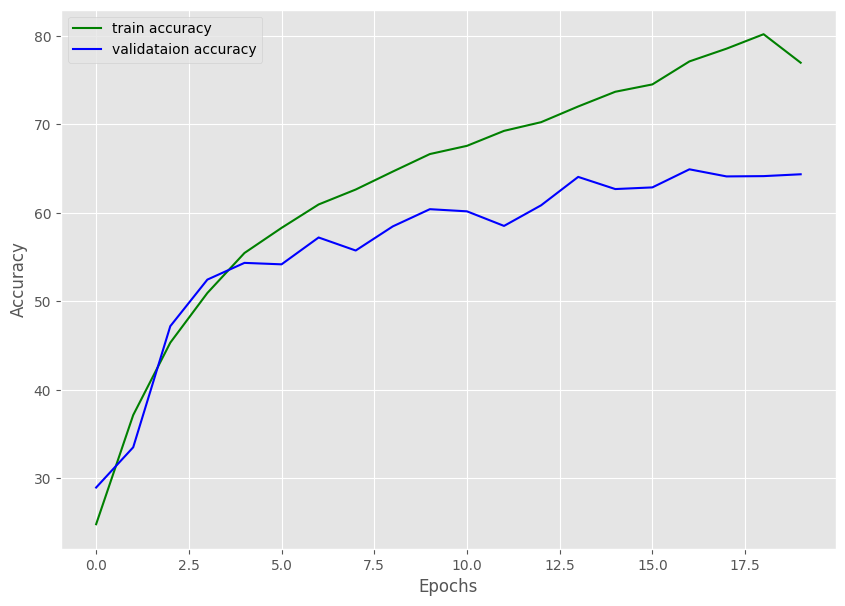

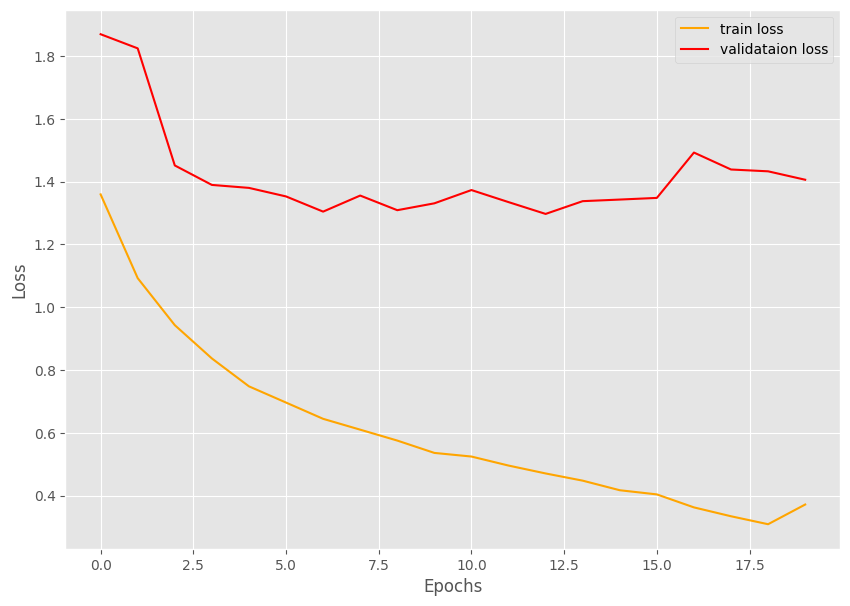

In [16]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(RA_model, RA_train_loader, 
                                            optimizer, loss_fn)
    valid_epoch_loss, valid_epoch_acc = validate(RA_model, RA_val_loader,  
                                                loss_fn)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(
        valid_epoch_loss, epoch, RA_model, optimizer, loss_fn, './models/RA_weight_best_model.pth'
    )
    print('-'*50)
    
# save the trained model weights for a final time
save_model(EPOCHS, RA_model, optimizer, loss_fn, './models/RA_weight_final_model.pth')
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss, './models/images/RA_weight_')
print('TRAINING COMPLETE')

In [17]:
checkpoint = torch.load('./models/RA_weight_best_model.pth')

model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_fn = checkpoint['loss']

In [18]:
prediction = []
with torch.no_grad():
    for _,label in RA_val_loader :
        image = _.to(device)
        pred = model(image)
        prediction.append(pred.cpu())

predicted_labels = []
for i in prediction:
    for j in i :
        predicted_labels.append(np.argmax(j.numpy()))

val_labels = []
for k,i in RA_val_set :
    val_labels.append(i)

In [19]:
val, tot = 0, 0
for i in range(len(val_labels)):
    if val_labels[i] == predicted_labels[i]:
        val += 1
    tot +=1
print(f"Précision totale sur le set de validation: {val/tot:.2f}")

valm, totm = 0, 0
liste = []
for i in range(len(val_labels)):
    if val_labels[i] == 3:
        liste.append([predicted_labels[i]])
        if val_labels[i] == predicted_labels[i] :
            valm += 1
        totm +=1
print(f"Précision sur la classe minoritaire du set de validation: {valm/totm:.2f}")

Précision totale sur le set de validation: 0.61
Précision sur la classe minoritaire du set de validation: 0.33
